# Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.linear_model import RANSACRegressor

from scipy.stats.mstats import normaltest

from fooof import FOOOF
from fooof.core.funcs import expo_nk_function as expf
from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.fake import SimFits, print_res
from apm.plts import plot_psds, plot_psds_two, plot_psds_shades
from apm.plts.fake import violin_errors, boxplot_errors
from apm.plts.utils import color_red_or_green
from apm.utils import exclude_spectrum

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

### Editorial Note

ToDo: remove old code.

In [3]:
# # # OLD:
# from apm.sim.peaks import _check_duplicate
# CEN_FREQS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/freqs.npy')
# PROBS = np.load('/Users/tom/Code/Projects/APMethods/AperiodicMethods/apm/sim/data/probs.npy')

# def gen_osc_def(n_oscs=None):
#     """Generate a plausible oscillation distribution for a synthetic PSD.
#     Parameters
#     ----------
#     n_oscs : int, optional
#         Number of oscillations to generate. If None, picked at random. Default: None.
#     Returns
#     -------
#     oscs : list of list of [float, float, float], or []
#         Oscillation definitions.
#     """

#     #
#     if n_oscs is None:
#         n_oscs = np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3])

#     # Initialize list of oscillation definitions
#     oscs = []

#     # Define the power and bandwidth possibilities and probabilities
#     #pow_opts = [0.05, 0.10, 0.15, 0.20]
#     pow_opts = [0.15, 0.25, 0.5, 1.0]
#     pow_probs = [0.25, 0.25, 0.25, 0.25]
#     bw_opts = [1, 1.5, 2]
#     bw_probs = [1/3, 1/3, 1/3]

#     # Generate oscillation definitions
#     for osc in range(n_oscs):

#         cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         while _check_duplicate(cur_cen, [it[0] for it in oscs]):
#             cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

#         cur_amp = np.random.choice(pow_opts, p=pow_probs)
#         cur_bw = np.random.choice(bw_opts, p=bw_probs)

#         oscs.append([cur_cen, cur_amp, cur_bw])

#     return oscs

## Settings

In [4]:
# Set up project database object
db = APMDB()

In [5]:
# Simulation settings
f_range = [3, 40]
off_val = 0
noise = 0.0

In [6]:
# Notebook Settings
SAVE_FIG = False
SAVE_DATA = True

## Spectral Fitting Methods

Here we demonstrate spectral fitting methods for measuring the aperiodic exponent by directly fitting power spectra.

The implementations of these methods are available in `apm/fit.py`.

### Example PSD

Load an example PSD, from eyes closed, resting state EEG data, extracted to the range of 3-40 Hz. 

In [7]:
# Load an example power spectrum to check fitting with
freqs = np.load('data/freqs.npy')
psd = np.load('data/psd.npy')

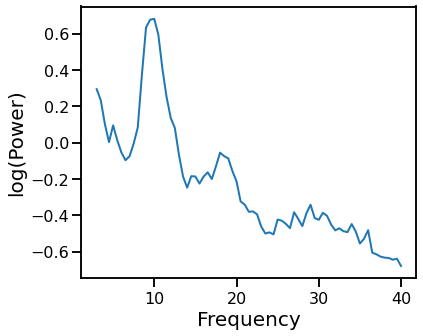

In [8]:
# Check a plot of the loaded power spectrum
plot_psds(freqs, psd)

### Methods for Fitting Power Spectra

In this section, we demonstrate a series of methods for fitting models to power spectra, including:
- Linear fits to power spectra in log-log spacing
- Robust linear fitting to power spectra in log-log spacing
- RANSAC linear fitting to power spectra in log-log spacing
- Exponential fits to power spectra in semi-log spacing

All of the above are done in the following versions:
- Across the entire spectrum
- Using a predefined exclusion zone of the alpha oscillation (7-14 Hz)
- Using exclusing zones for all oscillatory peaks

We also compare these approaches to a parameterizing neural power spectra (FOOOF). 

## Check FOOOF Fit of Data

In [9]:
# Initialize for collecting example fit results
example_results = {}

### Linear Fits (in log-log)

In [10]:
# Add constant for fitting with statsmodels
fx = sm.add_constant(np.log10(freqs))

#### OLS Linear Fit

Fit a line in log-log with Ordinary Least Squares (OLS).

In [11]:
# Spectral fit: linear fit
ex_fit_ols = sm.OLS(np.log10(psd), fx).fit()
#res_ols 
example_results['ols'] = ex_fit_ols.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols.fittedvalues)

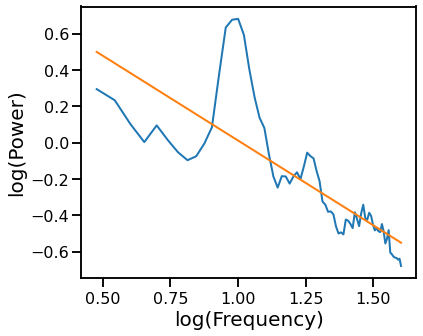

In [12]:
# Plot the aperiodic fit, from the OLS linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

In [13]:
### Robust Fit with RLM

In [14]:
# Spectral fit: robust linear fit to log-log PSD
ex_fit_rlm = sm.RLM(np.log10(psd), fx).fit()
#res_rlm 
example_results['rlm'] = ex_fit_rlm.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm.fittedvalues)

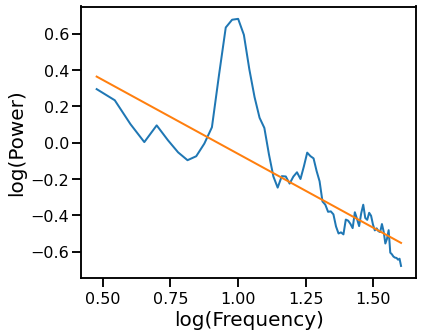

In [15]:
# Plot the aperiodic fit, from the robust linear fit
plot_psds(freqs, [psd, pred_vals], log_freqs=True)

In [16]:
### Robust Fit with RANSAC

In [17]:
# Reshape freqs for RANSAC fit
freqs_ran = freqs.reshape([len(freqs), 1])

In [18]:
# Initialize and fit with RANSAC
ex_ransac_model = RANSACRegressor()
ex_ransac_model.fit(np.log10(freqs_ran), np.log10(psd))
#res_ran 
example_results['ran'] = ex_ransac_model.estimator_.coef_[0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model.predict(np.log10(freqs_ran)))

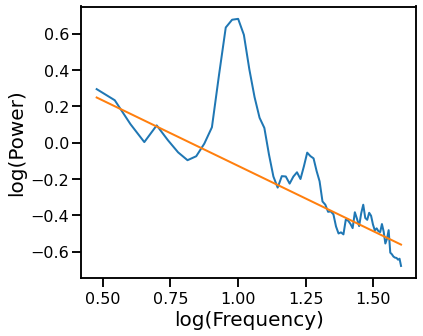

In [19]:
# Plot the aperiodic fit, from RANSAC
plot_psds(freqs_ran.flatten(), [psd, pred_vals], log_freqs=True)

## Spectral Fitting Excluding Alpha

Use a specific exclusion zone for the alpha oscillation.

In [20]:
# Exclude predefined alpha range
freqs_alph, psd_alph = exclude_spectrum(np.squeeze(freqs), psd, [7, 14])#, False)

# Reset freqs, with constant
fx_alph = sm.add_constant(np.log10(freqs_alph))

In [21]:
### Simple OLS Linear Fit Exlucing Generic Alpha Band

In [22]:
# Linear fit without alpha range
ex_fit_ols_alph = sm.OLS(np.log10(psd_alph), fx_alph).fit()
#res_ols_alph 
example_results['ols_alph'] = ex_fit_ols_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_alph.fittedvalues)

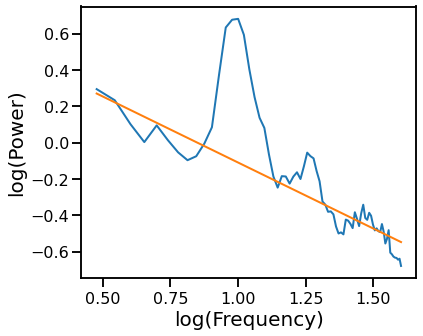

In [23]:
# Plot the aperiodic fit, from an OLS linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

### Robust Fit with RLM Excluding Generic Alpha Band

In [24]:
# Robust fit without alpha range
ex_fit_rlm_alph = sm.RLM(np.log10(psd_alph), fx_alph).fit()
#res_rlm_alph
example_results['rlm_alph'] = ex_fit_rlm_alph.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_alph.fittedvalues)

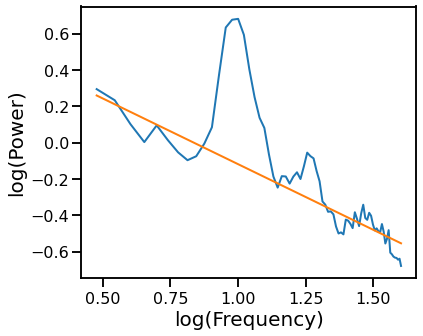

In [25]:
# Plot the aperiodic fit, from the robust linear fit with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

In [26]:
### Robust Fit with RANSAC Excluding Generic Alpha Band

In [27]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_alph = RANSACRegressor()
ex_ransac_model_alph.fit(np.log10(freqs_alph), np.log10(psd_alph))
#res_ran_alph 
example_results['ran_alph'] = ex_ransac_model_alph.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_alph.predict(np.log10(freqs_alph)))

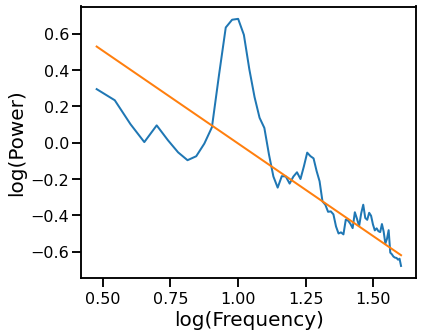

In [28]:
# Plot the aperiodic fit, from the RANSAC fit with alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

## Spectral Fit Excluding Oscillations

Use a exclusion zones for oscillations.

In [29]:
# Fit spectral model for finding peaks
fm = FOOOF(peak_width_limits=[1, 8])
fm.fit(freqs, psd, [3, 40])

In [30]:
# Get oscillation definitions from FOOOF
cens = fm.gaussian_params_[:, 0]
bws = fm.gaussian_params_[:, 2]

# Define oscillation ranges, as a range around each center frequency
m = 2
osc_ranges = [[cen-m*bw, cen+m*bw] for cen, bw in zip(cens, bws)]

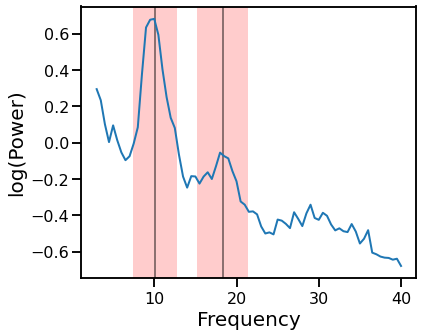

In [31]:
# Plot PSD with oscillatory regions shaded
plot_psds_shades(freqs, psd, osc_ranges)

In [32]:
# Exclude oscillation bands, as measured from FOOOF
psd_excl = psd
freqs_excl = np.squeeze(freqs)

for cen, bw in zip(cens, bws):
    freqs_excl, psd_excl = exclude_spectrum(freqs_excl, psd_excl, [cen-m*bw, cen+m*bw])

In [33]:
# Create a frequency vector with exlcusion zones for model fitting
fx_excl = sm.add_constant(np.log10(freqs_excl))

#### Simple Linear Fit Excluding Oscillatory Bands

In [34]:
# Linear fit without alpha range
ex_fit_ols_excl = sm.OLS(np.log10(psd_excl), fx_excl).fit()
#res_ols_excl
example_results['ols_excl'] = ex_fit_ols_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_ols_excl.fittedvalues)

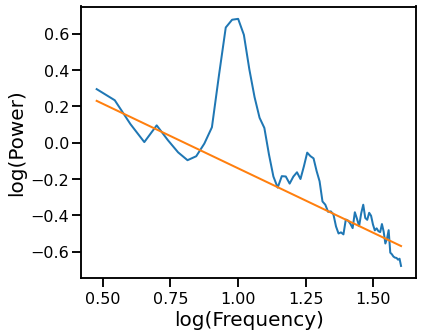

In [35]:
# Plot the aperiodic fit, from the OLS linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

In [36]:
### Robust Fit with RLM Excluding Oscillatory Bands

In [37]:
# Robust fit without oscillation bands
ex_fit_rlm_excl = sm.RLM(np.log10(psd_excl), fx_excl).fit()
#res_rlm_excl 
example_results['rlm_excl'] = ex_fit_rlm_excl.params[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_fit_rlm_excl.fittedvalues)

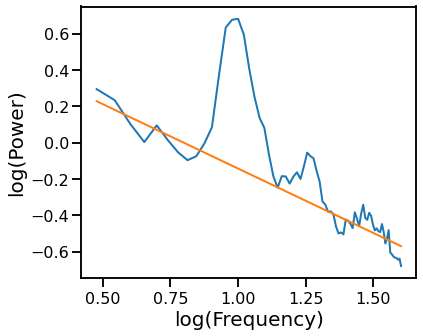

In [38]:
# Plot the aperiodic fit, from the robust linear fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

In [39]:
### Robust Fit with RANSAC Excluding Oscillatory Bands

In [40]:
# Fit alpha-exclusion with RANSAC
ex_ransac_model_excl = RANSACRegressor()
ex_ransac_model_excl.fit(np.log10(freqs_excl), np.log10(psd_excl))
#res_ran_excl 
example_results['ran_excl'] = ex_ransac_model_excl.estimator_.coef_[0][0]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, ex_ransac_model_excl.predict(np.log10(freqs_excl)))

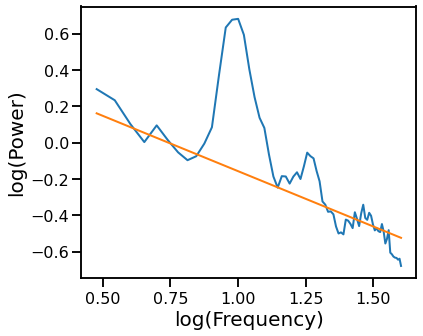

In [41]:
# Plot the aperiodic fit, from the RANSAC fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

In [42]:
## Exponential Fits

In [43]:
### Exponential Fit

In [44]:
# Fit exponential 1/f, with scipy curve_fit
ex_fit_exp, _ = curve_fit(expf, np.squeeze(freqs), np.squeeze(np.log10(psd)), p0=[1, 1])
#res_exp 
example_results['exp'] = -ex_fit_exp[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs, *ex_fit_exp))

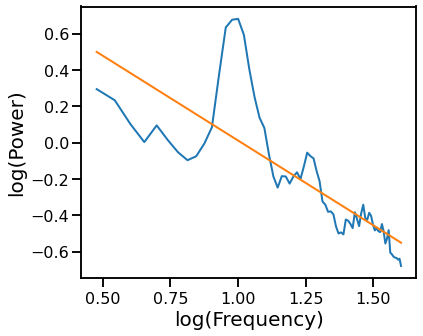

In [45]:
# Plot the aperiodic fit, from the exponential fit
plot_psds(freqs.flatten(), [psd, pred_vals], log_freqs=True)

In [46]:
### Exponential Fit Excluding Alpha Region

In [47]:
# Fit exponential 1/f, with scipy curve_fit, excluding alpha range
ex_fit_exp_alph, _ = curve_fit(expf, np.squeeze(freqs_alph), np.squeeze(np.log10(psd_alph)), p0=[1, 1])
#res_exp_alph 
example_results['exp_alph'] = -ex_fit_exp_alph[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_alph, *ex_fit_exp_alph))

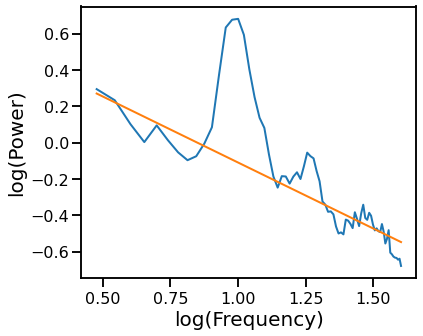

In [48]:
# Plot the aperiodic fit, from the exponential fit, with an alpha exclusion zone
plot_psds([freqs, freqs_alph], [psd, pred_vals], log_freqs=True)

In [49]:
### Exponential Fit Excluding Oscillation Regions

In [50]:
# Fit exponential 1/f, with scipy curve_fit, excluding oscillatory regions
ex_fit_exp_excl, _ = curve_fit(expf, np.squeeze(freqs_excl), np.squeeze(np.log10(psd_excl)), p0=[1, 1])
#res_exp_excl 
example_results['exp_excl'] = -ex_fit_exp_excl[1]

# Get the predicted values of the aperiodic fit
pred_vals = np.power(10, expf(freqs_excl, *ex_fit_exp_excl))

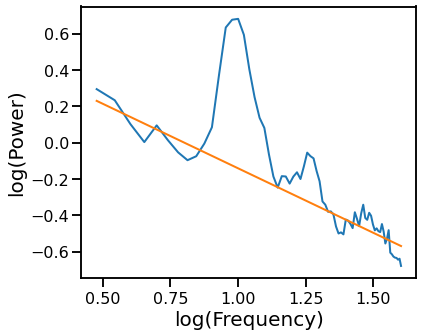

In [51]:
# Plot the aperiodic fit, from the exponential fit with oscillation exclusion zones
plot_psds([freqs, freqs_excl], [psd, pred_vals], log_freqs=True)

### FOOOF


FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offs

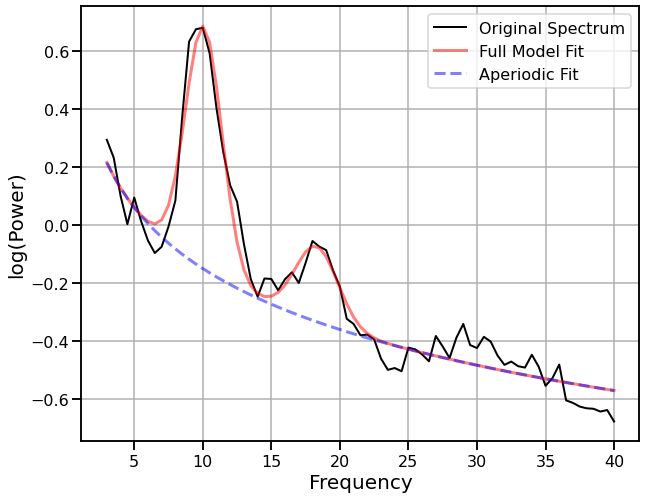

In [52]:
# Fit FOOOF model
fm = FOOOF()
fm.report(freqs, psd, [3, 40])
#res_fooof
example_results['fooof'] = -fm.aperiodic_params_[1]

### Compare Example Fits


In [53]:
# Print out results across all the different approaches
print('FIT RESULTS \n')
print('OLS: \t\t\t', example_results['ols'])
print('OLS-Exclude Alpha: \t', example_results['ols_alph'])
print('OLS-Exclude Oscs: \t', example_results['ols_alph'])
print('RLM: \t\t\t', example_results['rlm'])
print('RLM-Exclude Alpha:\t', example_results['rlm_alph'])
print('RLM-Exclude Oscs:\t', example_results['rlm_excl'])
print('RANSAC:\t\t\t', example_results['ran'])
print('RANSAC-Exclude Alpha:\t', example_results['ran_alph'])
print('RANSAC-Exclude Oscs:\t', example_results['ran_excl'])
print('EXP: \t\t\t', example_results['exp'])
print('EXP-Exclude Alpha:\t', example_results['exp_alph'])
print('EXP-Exclude Oscs:\t', example_results['exp_excl'])
print('FOOOF:\t\t\t', example_results['fooof'])

FIT RESULTS 

OLS: 			 -0.9330609141859378
OLS-Exclude Alpha: 	 -0.7264636275508257
OLS-Exclude Oscs: 	 -0.7264636275508257
RLM: 			 -0.8133822433582691
RLM-Exclude Alpha:	 -0.7228972545346244
RLM-Exclude Oscs:	 -0.708775808369718
RANSAC:			 -0.7193521694534935
RANSAC-Exclude Alpha:	 -1.0204288976077298
RANSAC-Exclude Oscs:	 -0.6088968886060747
EXP: 			 -0.9330609131352398
EXP-Exclude Alpha:	 -0.7264636284120363
EXP-Exclude Oscs:	 -0.7099949804395156
FOOOF:			 -0.6997271952029382


In [54]:
# # Order fits by magnitude
# # TO FIX USING DICTIONARY
# all_res_fits = [(res_ols, 'OLS'), (res_ols_alph, 'OLS-EA'), (res_ols_excl, 'OLS-EO'),
#                 (res_rlm, 'RLM'), (res_rlm_alph, 'RLM-EA'), (res_rlm_excl, 'RLM-EO'),
#                 (res_ran, 'RAN'), (res_ran_alph, 'RAN-EA'), (res_ran_excl, 'RAN-EO'),
#                 (res_exp, 'EXP'), (res_exp_alph, 'EXP-EA'), (res_exp_excl, 'EXP-EO'),
#                 (res_fooof, 'FOOOF')]

# all_res_fits.sort()
# all_res_fits.reverse()

# # Print out in order of fit magnitude
# print('FIT RESULTS (SORTED):')
# for fit in all_res_fits:
#     print('\t {:1.5f} \t {}'.format(*fit))

## Check out PSD generation and test fitting

In [55]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()
peaks = next(peak_gen)

In [56]:
# # Old version
# freqs, psd = sim_psd(f_range, exp_val, peaks, noise)
# # Plot and check a simulated spectrum, plotted in semi-log and log space
# plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [57]:
# Simulate an example power spectrum
freqs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

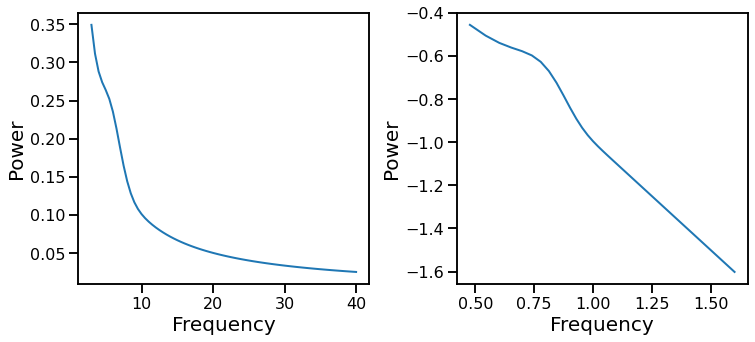

In [58]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(freqs, psd, np.log10(freqs), np.log10(psd))

In [59]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(freqs, psd))
print('RLM fit: \t', fit_rlm(freqs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(freqs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(freqs, psd))
print('RAN fit: \t', fit_ransac(freqs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(freqs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(freqs, psd))
print('EXP fit: \t', fit_exp(freqs, psd))
print('EXP-EA fit: \t', fit_exp_alph(freqs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(freqs, psd))
print('FOOOF fit: \t', fit_fooof(freqs, psd))

True exponent value is  1 

OLS fit: 	 -1.0883203774502257
RLM fit: 	 -1.0351436188150431
RLM-EA fit: 	 -1.0383346402145137
RLM-EO fit: 	 -1.000103624368095
RAN fit: 	 -1.0883203774502261
RAN-EA fit: 	 -1.0592289696222783
RAN-EO fit: 	 -1.017382714850246
EXP fit: 	 -1.0883203777077215
EXP-EA fit: 	 -1.0941251425612148
EXP-EO fit: 	 -1.0173827148821575
FOOOF fit: 	 -1.0241205023941198


## Run a Fits on Simulated Power Spectra

In [60]:
# Settings
n_psds = 150
f_range = [3, 40]
exp_val = 1
noise = 0.05

In [61]:
# # OLD: Simulate a group of PSDs
# freqs, psds = sim_n_psds(n_psds, f_range, exp_val, gen_osc_def, noise)

In [62]:
# NEW VERSION.
freqs, psds, sim_params = gen_group_power_spectra(\
    n_psds, f_range, [off_val, exp_val], gen_peak_def(), noise, return_params=True)

# TEMP:
psds = psds.T

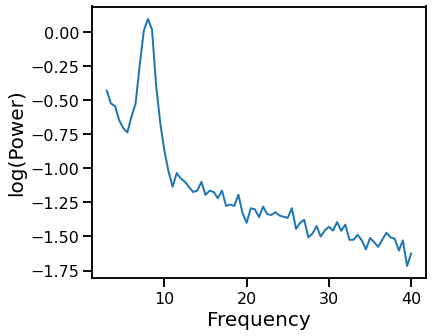

In [63]:
# Plot example simulated power spectrum from the group
plot_psds(freqs, psds[:, 10])

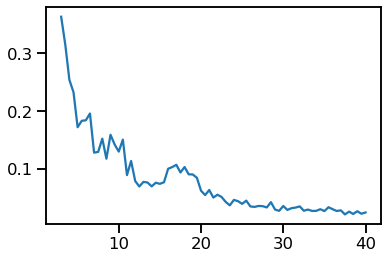

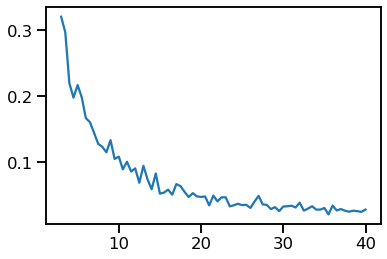

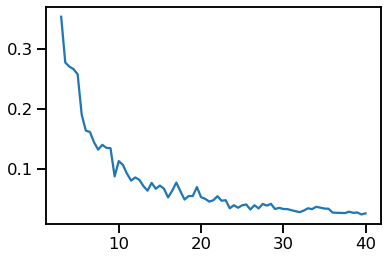

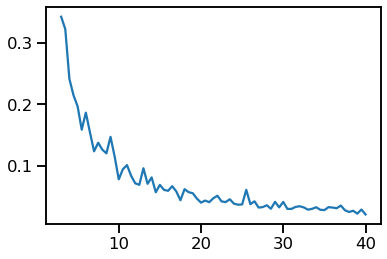

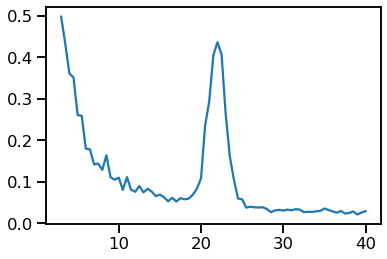

In [64]:
# Check out some of the simulated power spectra
for ind, psd in enumerate(psds.T):
    if ind < 5:
        plt.figure()
        plt.plot(freqs, psd)

In [65]:
# Initialize and set up for simulated data testing
sims = SimFits()
sims.get_fit_funcs()

In [66]:
# Check the fitting functions being used
print(list(sims.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [67]:
# Fit spectra: this fits all methods
sims.fit_spectra(exp_val, freqs, psds)

In [68]:
# Calculate metrics
avgs = sims.calc_avg_errs()
perc_good = sims.calc_perc_good()

In [69]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   RLM-EO   		 0.02279
   EXP-EO   		 0.02293
   OLS-EO   		 0.02293
   FOOOF    		 0.02362
   RAN-EO   		 0.02561
   RLM-EA   		 0.02573
   RAN      		 0.02794
   OLS-EA   		 0.03266
   EXP-EA   		 0.03266
   RAN-EA   		 0.03436
   RLM      		 0.03504
   OLS      		 0.05065
   EXP      		 0.05065


In [70]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   RLM-EO   		 0.54667
   OLS-EO   		 0.53333
   EXP-EO   		 0.53333
   FOOOF    		 0.51333
   RAN-EO   		 0.50000
   RLM-EA   		 0.48667
   RAN      		 0.48000
   RAN-EA   		 0.41333
   RLM      		 0.40667
   OLS-EA   		 0.40000
   EXP-EA   		 0.40000
   OLS      		 0.34000
   EXP      		 0.34000


In [71]:
# Create a dataframe of the simulation errors
df = pd.DataFrame(sims.errs)

In [72]:
# Check the correlation structure between fit errors
df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.783202,0.600814,0.918570,0.718378,0.608835,0.638464,0.253595,0.257013,1.000000,0.783202,0.600814,0.704495
OLS-EA,0.783202,1.000000,0.808496,0.831746,0.967431,0.763596,0.773270,0.477587,0.278672,0.783202,1.000000,0.808496,0.888271
OLS-EO,0.600814,0.808496,1.000000,0.633732,0.842989,0.951298,0.735486,0.477922,0.509363,0.600814,0.808496,1.000000,0.955084
RLM,0.918570,0.831746,0.633732,1.000000,0.794927,0.654149,0.718510,0.302116,0.300456,0.918570,0.831746,0.633732,0.745495
RLM-EA,0.718378,0.967431,0.842989,0.794927,1.000000,0.767291,0.835739,0.549219,0.287223,0.718378,0.967431,0.842989,0.904147
RLM-EO,0.608835,0.763596,0.951298,0.654149,0.767291,1.000000,0.643744,0.377232,0.598601,0.608835,0.763596,0.951298,0.911517
RAN,0.638464,0.773270,0.735486,0.718510,0.835739,0.643744,1.000000,0.481008,0.270684,0.638464,0.773270,0.735486,0.774196
RAN-EA,0.253595,0.477587,0.477922,0.302116,0.549219,0.377232,0.481008,1.000000,0.104727,0.253595,0.477587,0.477922,0.467308
RAN-EO,0.257013,0.278672,0.509363,0.300456,0.287223,0.598601,0.270684,0.104727,1.000000,0.257013,0.278672,0.509363,0.395375
EXP,1.000000,0.783202,0.600814,0.918570,0.718378,0.608835,0.638464,0.253595,0.257013,1.000000,0.783202,0.600814,0.704495


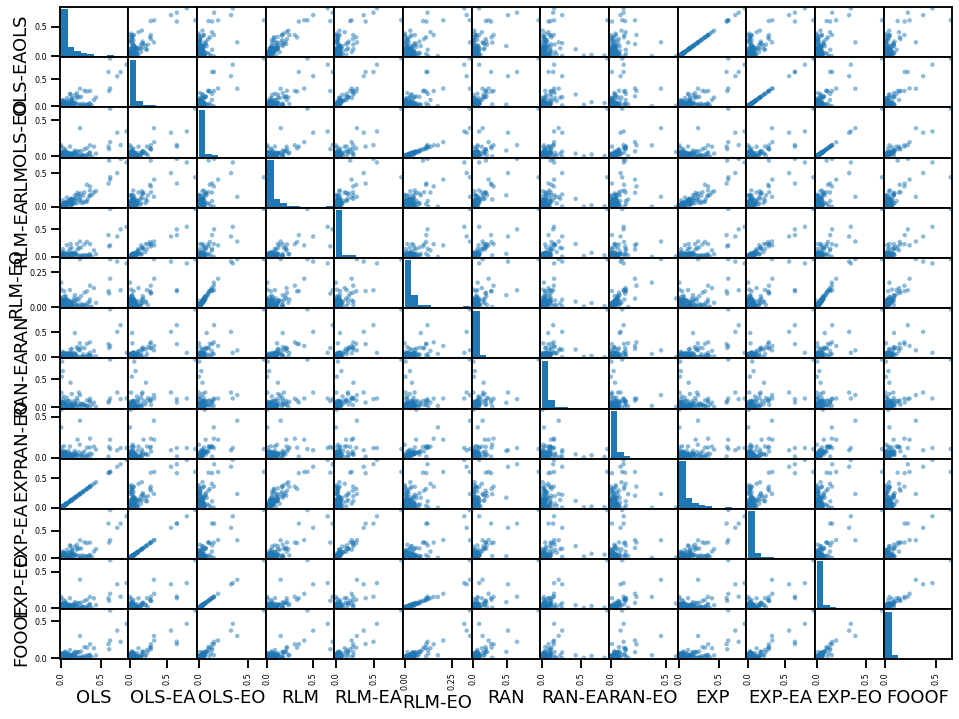

In [73]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [74]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
OLS,0.000000
OLS-EA,0.000000
OLS-EO,0.000000
RLM,0.000000
RLM-EA,0.000000
RLM-EO,0.000000
RAN,0.000000
RAN-EA,0.000000
RAN-EO,0.000000
EXP,0.000000


In [75]:
# Save out simulated fit data to pickle
if SAVE_DATA:
    save_pickle(sims.errs, 'SimFits_test.p', db.sims_path)

In [76]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
f_ind = sim_files.index('SimFits_test.p')

In [77]:
# # Load simulated fit results data from pickle file
# data = load_pickle(sim_files[f_ind], db.sims_path)
# sim_dat = SimFits()
# sim_dat.errs = data

In [78]:
## RELOAD FILE

# # Check available simulated model fit files
# sim_files = db.check_files('sims')
# sim_files

# # Collect all fits together
# all_fits = SimFits()
# all_fits.get_fit_funcs()
# all_fits.get_err_dict(0)

# for f_name in sim_files:

#     data = load_pickle(f_name, db.sims_path)

#     temp = SimFits()
#     temp.errs = data
    
#     all_fits = all_fits + temp

## Compare Spectral Fitting

In [79]:
# Check how many PSDs are included in simulated data model fits
print(len(sims.errs['RAN-EA']))

150


In [80]:
# Check the average errors per method
print_res(sims.calc_avg_errs(avg='mean'))

   RLM-EO   		 0.04091
   EXP-EO   		 0.04398
   OLS-EO   		 0.04398
   FOOOF    		 0.04644
   RAN-EO   		 0.04751
   RLM-EA   		 0.05956
   RAN      		 0.06284
   RAN-EA   		 0.06983
   EXP-EA   		 0.07590
   OLS-EA   		 0.07590
   RLM      		 0.07912
   EXP      		 0.11821
   OLS      		 0.11821


In [81]:
# Check the standard deviation of errors per method
print_res(sims.calc_std_errs())

   RLM-EO   		 0.06010
   RAN-EO   		 0.07474
   EXP-EO   		 0.07624
   OLS-EO   		 0.07624
   FOOOF    		 0.08094
   RLM-EA   		 0.11057
   RAN      		 0.11849
   RLM      		 0.12349
   RAN-EA   		 0.12425
   EXP-EA   		 0.13443
   OLS-EA   		 0.13443
   EXP      		 0.15972
   OLS      		 0.15972


In [82]:
# Check the number of fits that pass a threshold, per method
print_res(sims.calc_perc_good(thresh=0.025))

   RLM-EO   		 0.54667
   OLS-EO   		 0.53333
   EXP-EO   		 0.53333
   FOOOF    		 0.51333
   RAN-EO   		 0.50000
   RLM-EA   		 0.48667
   RAN      		 0.48000
   RAN-EA   		 0.41333
   RLM      		 0.40667
   OLS-EA   		 0.40000
   EXP-EA   		 0.40000
   OLS      		 0.34000
   EXP      		 0.34000


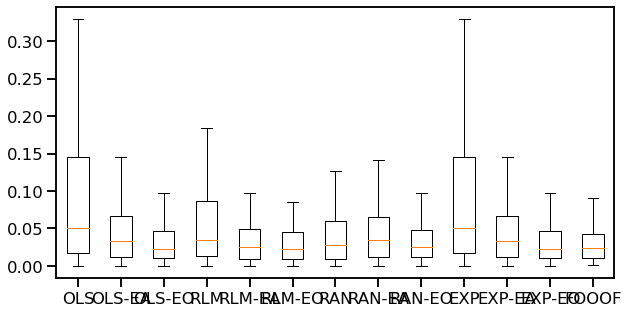

In [83]:
# Create boxplot of errors
boxplot_errors(sims.errs)

In [84]:
mains = ['OLS', 'RLM', 'RAN', 'EXP', 'FOOOF']
alphas = ['OLS-EA', 'RLM-EA', 'RAN-EA', 'EXP-EA', 'FOOOF']
oscs = ['OLS-EO', 'RLM-EO', 'RAN-EO', 'EXP-EO', 'FOOOF']

In [85]:
main_dicts = {label : sims.errs[label] for label in mains}
alphas_dicts = {label : sims.errs[label] for label in alphas}
oscs_dicts = {label : sims.errs[label] for label in oscs}

## Violin Plots

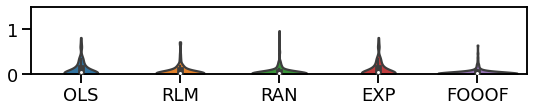

In [86]:
violin_errors(main_dicts, ylim=[0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-Main', file_type='pdf')) 

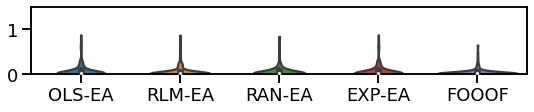

In [87]:
violin_errors(alphas_dicts, ylim=[0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EA', file_type='pdf'))

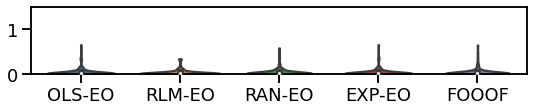

In [88]:
violin_errors(oscs_dicts, ylim = [0, 1.5])

if SAVE_FIG:
    plt.savefig(db.make_fig_name('SpectralFitting-EO', file_type='pdf'))

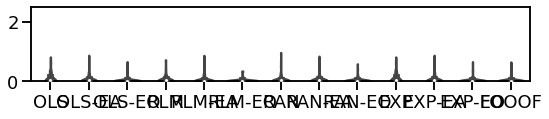

In [89]:
# Violin plot of error distributions
ax = violin_errors(sims.errs, ylim=[0, 2.5])

#if SAVE_FIG:
#    plt.savefig(db.make_fig_name('violin_plot', file_type='pdf'))

## Statistically Compare Methods

In [90]:
# Run comparisons between methods
comps = sims.comp_errs()

In [91]:
# Print out color-coded dataframe of comparison results
df = pd.DataFrame(comps, index=sims.errs.keys(), columns=sims.errs.keys())
df.style.applymap(color_red_or_green)

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.005079,0.000001,0.029727,0.000021,0.000000,0.000140,0.005380,0.000023,0.992566,0.005079,0.000001,0.000003
OLS-EA,0.005079,1.000000,0.020843,0.412994,0.080506,0.013744,0.280349,0.847471,0.137053,0.005079,0.992566,0.020843,0.041957
OLS-EO,0.000001,0.020843,1.000000,0.002292,0.658539,0.895158,0.295749,0.010276,0.372474,0.000001,0.020843,0.997876,0.761513
RLM,0.029727,0.412994,0.002292,1.000000,0.014053,0.001549,0.062196,0.506545,0.024139,0.029727,0.412994,0.002292,0.004853
RLM-EA,0.000021,0.080506,0.658539,0.014053,1.000000,0.571581,0.532435,0.054757,0.696524,0.000021,0.080506,0.658539,0.915194
RLM-EO,0.000000,0.013744,0.895158,0.001549,0.571581,1.000000,0.227821,0.007372,0.302877,0.000000,0.013744,0.895158,0.694556
RAN,0.000140,0.280349,0.295749,0.062196,0.532435,0.227821,1.000000,0.183589,0.820976,0.000142,0.280349,0.295442,0.401692
RAN-EA,0.005380,0.847471,0.010276,0.506545,0.054757,0.007372,0.183589,1.000000,0.090168,0.005380,0.844865,0.010276,0.021666
RAN-EO,0.000023,0.137053,0.372474,0.024139,0.696524,0.302877,0.820976,0.090168,1.000000,0.000023,0.137053,0.370337,0.532435
EXP,0.992566,0.005079,0.000001,0.029727,0.000021,0.000000,0.000142,0.005380,0.000023,1.000000,0.005079,0.000001,0.000003
